In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange
import scipy.stats
import pandas as pd
from scipy.stats import rankdata
import matplotlib as mpl

# Weighted Corr

In [2]:
class WeightedCorr:
    def __init__(self, xyw=None, x=None, y=None, w=None, df=None, wcol=None):
        ''' Weighted Correlation class. Either supply xyw, (x, y, w), or (df, wcol). Call the class to get the result, i.e.:
        WeightedCorr(xyw=mydata[[x, y, w]])(method='pearson')
        :param xyw: pd.DataFrame with shape(n, 3) containing x, y, and w columns (column names irrelevant)
        :param x: pd.Series (n, ) containing values for x
        :param y: pd.Series (n, ) containing values for y
        :param w: pd.Series (n, ) containing weights
        :param df: pd.Dataframe (n, m+1) containing m phenotypes and a weight column
        :param wcol: str column of the weight column in the dataframe passed to the df argument.
        '''
        if (df is None) and (wcol is None):
            if np.all([i is None for i in [xyw, x, y, w]]):
                raise ValueError('No data supplied')
            if not ((isinstance(xyw, pd.DataFrame)) != (np.all([isinstance(i, pd.Series) for i in [x, y, w]]))):
                raise TypeError('xyw should be a pd.DataFrame, or x, y, w should be pd.Series')
            xyw = pd.concat([x, y, w], axis=1).dropna() if xyw is None else xyw.dropna()
            self.x, self.y, self.w = (pd.to_numeric(xyw[i], errors='coerce').values for i in xyw.columns)
            self.df = None
        elif (wcol is not None) and (df is not None):
            if (not isinstance(df, pd.DataFrame)) or (not isinstance(wcol, str)):
                raise ValueError('df should be a pd.DataFrame and wcol should be a string')
            if wcol not in df.columns:
                raise KeyError('wcol not found in column names of df')
            self.df = df.loc[:, [x for x in df.columns if x != wcol]]
            self.w = pd.to_numeric(df.loc[:, wcol], errors='coerce')
        else:
            raise ValueError('Incorrect arguments specified, please specify xyw, or (x, y, w) or (df, wcol)')

    def _wcov(self, x, y, ms):
        return np.sum(self.w * (x - ms[0]) * (y - ms[1]))

    def _pearson(self, x=None, y=None):
        x, y = (self.x, self.y) if ((x is None) and (y is None)) else (x, y)
        mx, my = (np.sum(i * self.w) / np.sum(self.w) for i in [x, y])
        return self._wcov(x, y, [mx, my]) / np.sqrt(self._wcov(x, x, [mx, mx]) * self._wcov(y, y, [my, my]))

    def _wrank(self, x):
        (unique, arr_inv, counts) = np.unique(rankdata(x), return_counts=True, return_inverse=True)
        a = np.bincount(arr_inv, self.w)
        return (np.cumsum(a) - a)[arr_inv]+((counts + 1)/2 * (a/counts))[arr_inv]

    def _spearman(self, x=None, y=None):
        x, y = (self.x, self.y) if ((x is None) and (y is None)) else (x, y)
        return self._pearson(self._wrank(x), self._wrank(y))

    def __call__(self, method='pearson'):
        '''
        :param method: Correlation method to be used: 'pearson' for pearson r, 'spearman' for spearman rank-order correlation.
        :return: if xyw, or (x, y, w) were passed to __init__ returns the correlation value (float).
                 if (df, wcol) were passed to __init__ returns a pd.DataFrame (m, m), the correlation matrix.
        '''
        if method not in ['pearson', 'spearman']:
            raise ValueError('method should be one of [\'pearson\', \'spearman\']')
        cor = {'pearson': self._pearson, 'spearman': self._spearman}[method]
        if self.df is None:
            return cor()
        else:
            out = pd.DataFrame(np.nan, index=self.df.columns, columns=self.df.columns)
            for i, x in enumerate(self.df.columns):
                for j, y in enumerate(self.df.columns):
                    if i >= j:
                        out.loc[x, y] = cor(x=pd.to_numeric(self.df[x], errors='coerce'), y=pd.to_numeric(self.df[y], errors='coerce'))
                        out.loc[y, x] = out.loc[x, y]
            return out

# RSA

In [3]:
rep_no = 5

C4_diff_all = np.zeros((rep_no, 2000,2000))
C4_nona_all = np.zeros((rep_no, 2000,2000))
C8_diff_all = np.zeros((rep_no, 2000,2000))
C8_nona_all = np.zeros((rep_no, 2000,2000))
C12_diff_all = np.zeros((rep_no, 2000,2000))
C12_nona_all = np.zeros((rep_no, 2000,2000))

C4_diff_scale_all = np.zeros((rep_no, 2000))
C4_nona_scale_all = np.zeros((rep_no, 2000))
C8_diff_scale_all = np.zeros((rep_no, 2000))
C8_nona_scale_all = np.zeros((rep_no, 2000))
C12_diff_scale_all = np.zeros((rep_no, 2000))
C12_nona_scale_all = np.zeros((rep_no, 2000))

C4_rand_all = np.zeros((rep_no, 2000, 2000))
C4_rand_scale_all = np.random.rand(rep_no, 2000)
C8_rand_all = np.zeros((rep_no, 2000, 2000))
C8_rand_scale_all = np.random.rand(rep_no, 2000)
C12_rand_all = np.zeros((rep_no, 2000, 2000))
C12_rand_scale_all = np.random.rand(rep_no, 2000)

for i in tnrange(rep_no):
    C4_diff_raw = np.load("/media/hdd01/sklee/CA1_clust4-60/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C4_nona_raw = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C8_diff_raw = np.load("/media/hdd01/sklee/CA1_clust8-30/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C8_nona_raw = np.load("/media/hdd01/sklee/CA1_clust8-30_noNA/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C12_diff_raw = np.load("/media/hdd01/sklee/CA1_clust12-20/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C12_nona_raw = np.load("/media/hdd01/sklee/CA1_clust12-20_noNA/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]

    C4_dist_raw = np.load("/media/hdd01/sklee/CA1_clust4-60/data/clust4_syn_dist.npy")[:,-1]
    C8_dist_raw = np.load("/media/hdd01/sklee/CA1_clust8-30/data/clust8_syn_dist.npy")[:,-1]
    C12_dist_raw = np.load("/media/hdd01/sklee/CA1_clust12-20/data/clust12_syn_dist.npy")[:,-1]

    C4_diff_scale = np.load("/media/hdd01/sklee/CA1_clust4-60/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C4_nona_scale = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C8_diff_scale = np.load("/media/hdd01/sklee/CA1_clust8-30/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C8_nona_scale = np.load("/media/hdd01/sklee/CA1_clust8-30_noNA/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C12_diff_scale = np.load("/media/hdd01/sklee/CA1_clust12-20/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C12_nona_scale = np.load("/media/hdd01/sklee/CA1_clust12-20_noNA/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    
    C4_diff_scale_all[i] = C4_diff_scale
    C4_nona_scale_all[i] = C4_nona_scale
    C8_diff_scale_all[i] = C8_diff_scale
    C8_nona_scale_all[i] = C8_nona_scale
    C12_diff_scale_all[i] = C12_diff_scale
    C12_nona_scale_all[i] = C12_nona_scale
    
    C4_diff_idx = np.zeros((2000))
    C4_nona_idx = np.zeros((2000))
    C8_diff_idx = np.zeros((2000))
    C8_nona_idx = np.zeros((2000))
    C12_diff_idx = np.zeros((2000))
    C12_nona_idx = np.zeros((2000))
    
    C4_rand_idx = np.random.randint(0,5,(2000))
    C8_rand_idx = np.random.randint(0,8,(2000))
    C12_rand_idx = np.random.randint(0,12,(2000))

    for j in range(2000):
        C4_diff_idx[j] = np.argmax(C4_diff_raw[:,j])
        C4_nona_idx[j] = np.argmax(C4_nona_raw[:,j])
        C8_diff_idx[j] = np.argmax(C8_diff_raw[:,j])
        C8_nona_idx[j] = np.argmax(C8_nona_raw[:,j])
        C12_diff_idx[j] = np.argmax(C12_diff_raw[:,j])
        C12_nona_idx[j] = np.argmax(C12_nona_raw[:,j])

    for j in range(2000):
        for k in range(2000):
            if C4_diff_idx[j] != C4_diff_idx[k]:
                C4_diff_all[i,j,k] = 1
                C4_diff_all[i,k,j] = 1
            if C4_nona_idx[j] != C4_nona_idx[k]:
                C4_nona_all[i,j,k] = 1
                C4_nona_all[i,k,j] = 1
            if C8_diff_idx[i] != C8_diff_idx[k]:
                C8_diff_all[i,j,k] = 1
                C8_diff_all[i,k,j] = 1
            if C8_nona_idx[j] != C8_nona_idx[k]:
                C8_nona_all[i,j,k] = 1
                C8_nona_all[i,k,j] = 1
            if C12_diff_idx[j] != C12_diff_idx[k]:
                C12_diff_all[i,j,k] = 1
                C12_diff_all[i,k,j] = 1
            if C12_nona_idx[j] != C12_nona_idx[k]:
                C12_nona_all[i,j,k] = 1
                C12_nona_all[i,k,j] = 1
            if C4_rand_idx[j] != C4_rand_idx[k]:
                C4_rand_all[i,j,k] = 1
                C4_rand_all[i,k,j] = 1
            if C8_rand_idx[j] != C8_rand_idx[k]:
                C8_rand_all[i,j,k] = 1
                C8_rand_all[i,k,j] = 1
            if C12_rand_idx[j] != C12_rand_idx[k]:
                C12_rand_all[i,j,k] = 1
                C12_rand_all[i,k,j] = 1

<ipython-input-3-b09bc4eb957b>:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(rep_no):


  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
C4_clust_idx = np.zeros((2000))
C8_clust_idx = np.zeros((2000))
C12_clust_idx = np.zeros((2000))

for i in range(4):
    C4_clust_idx[880+60*i:880+60*(i+1)] = i+1
for i in range(8):
    C8_clust_idx[880+30*i:880+30*(i+1)] = i+1
for i in range(12):
    C12_clust_idx[880+20*i:880+20*(i+1)] = i+1
    
C4_clust = np.zeros((2000,2000))
C8_clust = np.zeros((2000,2000))
C12_clust = np.zeros((2000,2000))

for i in tnrange(2000):
    for j in range(2000):
        if C4_clust_idx[i] != C4_clust_idx[j]:
            C4_clust[i,j] = 1
            C4_clust[j,i] = 1
        if C8_clust_idx[i] != C8_clust_idx[j]:
            C8_clust[i,j] = 1
            C8_clust[j,i] = 1
        if C12_clust_idx[i] != C12_clust_idx[j]:
            C12_clust[i,j] = 1
            C12_clust[j,i] = 1

<ipython-input-4-28c7df3d81b5>:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(2000):


  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
C4_dist = np.zeros((2000,2000))
C8_dist = np.zeros((2000,2000))
C12_dist = np.zeros((2000,2000))

for i in tnrange(2000):
    for j in range(2000):
        C4_dist[i,j] = np.abs(C4_dist_raw[i] - C4_dist_raw[j])
        C8_dist[i,j] = np.abs(C8_dist_raw[i] - C8_dist_raw[j])
        C12_dist[i,j] = np.abs(C12_dist_raw[i] - C12_dist_raw[j])

<ipython-input-5-e900bb5569b8>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(2000):


  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
x, y = np.triu_indices(2000, k=0)
x_part, y_part = np.triu_indices(240, k=0)
x_part += 880
y_part += 880

within_corrs_weighted = np.zeros((rep_no*(rep_no-1)//2,9))
across_corrs_weighted = np.zeros((rep_no**2,3))
dist_corrs_weighted = np.zeros((rep_no,9))
clust_corrs_weighted = np.zeros((rep_no,9))

C4_diff_scale_mat_all = np.matmul(C4_diff_scale_all.reshape(rep_no,-1,1), C4_diff_scale_all.reshape(rep_no,1,-1))
C4_nona_scale_mat_all = np.matmul(C4_nona_scale_all.reshape(rep_no,-1,1), C4_nona_scale_all.reshape(rep_no,1,-1))
C8_diff_scale_mat_all = np.matmul(C8_diff_scale_all.reshape(rep_no,-1,1), C8_diff_scale_all.reshape(rep_no,1,-1))
C8_nona_scale_mat_all = np.matmul(C8_nona_scale_all.reshape(rep_no,-1,1), C8_nona_scale_all.reshape(rep_no,1,-1))
C12_diff_scale_mat_all = np.matmul(C12_diff_scale_all.reshape(rep_no,-1,1), C12_diff_scale_all.reshape(rep_no,1,-1))
C12_nona_scale_mat_all = np.matmul(C12_nona_scale_all.reshape(rep_no,-1,1), C12_nona_scale_all.reshape(rep_no,1,-1))
C4_rand_scale_mat_all = np.matmul(C4_rand_scale_all.reshape(rep_no,-1,1), C4_rand_scale_all.reshape(rep_no,1,-1))
C8_rand_scale_mat_all = np.matmul(C8_rand_scale_all.reshape(rep_no,-1,1), C8_rand_scale_all.reshape(rep_no,1,-1))
C12_rand_scale_mat_all = np.matmul(C12_rand_scale_all.reshape(rep_no,-1,1), C12_rand_scale_all.reshape(rep_no,1,-1))

for i in tnrange(3):
    if i == 0:
        dist_mat = C4_dist
        clust_mat = C4_clust
        diff_mat_all = C4_diff_all
        nona_mat_all = C4_nona_all
        diff_scale_mat_all = C4_diff_scale_mat_all
        nona_scale_mat_all = C4_nona_scale_mat_all
        rand_mat_all = C4_rand_all
        rand_scale_mat_all = C4_rand_scale_mat_all

    elif i == 1:
        dist_mat = C8_dist
        clust_mat = C8_clust
        diff_mat_all = C8_diff_all
        nona_mat_all = C8_nona_all
        diff_scale_mat_all = C8_diff_scale_mat_all
        nona_scale_mat_all = C8_nona_scale_mat_all
        rand_mat_all = C8_rand_all
        rand_scale_mat_all = C8_rand_scale_mat_all

    elif i == 2:
        dist_mat = C12_dist
        clust_mat = C12_clust
        diff_mat_all = C12_diff_all
        nona_mat_all = C12_nona_all
        diff_scale_mat_all = C12_diff_scale_mat_all
        nona_scale_mat_all = C12_nona_scale_mat_all
        rand_mat_all = C12_rand_all
        rand_scale_mat_all = C12_rand_scale_mat_all
        
    across_count = 0
    within_count = 0
    for j in range(rep_no):
        for k in range(rep_no):
            weight = diff_scale_mat_all[j][x,y] * nona_scale_mat_all[k][x,y]
            across_corr_val = WeightedCorr(x=pd.Series(diff_mat_all[j][x,y]),
                   y=pd.Series(nona_mat_all[k][x,y]),
                   w=pd.Series(weight))(method='spearman')
            across_corrs_weighted[across_count,i] = across_corr_val
            across_count += 1
        for k in range(j+1,rep_no,1):
            diff_weight = diff_scale_mat_all[j][x,y] * diff_scale_mat_all[k][x,y]
            nona_weight = nona_scale_mat_all[j][x,y] * nona_scale_mat_all[k][x,y]
            within_diff_corr_val = WeightedCorr(x=pd.Series(diff_mat_all[j][x,y]),
                   y=pd.Series(diff_mat_all[k][x,y]),
                   w=pd.Series(diff_weight))(method='spearman')
            within_nona_corr_val = WeightedCorr(x=pd.Series(nona_mat_all[j][x,y]),
                   y=pd.Series(nona_mat_all[k][x,y]),
                   w=pd.Series(nona_weight))(method='spearman')
            within_corrs_weighted[within_count,i*2] = within_nona_corr_val
            within_corrs_weighted[within_count,i*2+1] = within_diff_corr_val
            
            rand_weight = rand_scale_mat_all[j][x,y] * rand_scale_mat_all[k][x,y]
            within_rand_corr_val = WeightedCorr(x=pd.Series(rand_mat_all[j][x,y]),
                   y=pd.Series(rand_mat_all[k][x,y]),
                   w=pd.Series(rand_weight))(method='spearman')
            within_corrs_weighted[within_count,i+6] = within_rand_corr_val            
            
            within_count += 1
        
        nona_weight = nona_scale_mat_all[j][x,y]
        diff_weight = diff_scale_mat_all[j][x,y]
        dist_nona_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(nona_mat_all[j][x,y]),
                   w=pd.Series(nona_weight))(method='spearman')
        dist_diff_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(diff_mat_all[j][x,y]),
                   w=pd.Series(diff_weight))(method='spearman')
        dist_corrs_weighted[j,i*2] = dist_nona_corr_val
        dist_corrs_weighted[j,i*2+1] = dist_diff_corr_val
        rand_weight = rand_scale_mat_all[j][x,y]
        dist_rand_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(rand_mat_all[j][x,y]),
                   w=pd.Series(rand_weight))(method='spearman')
        dist_corrs_weighted[j,i+6] = dist_rand_corr_val
        
        nona_weight_part = nona_scale_mat_all[j][x_part,y_part]
        diff_weight_part = diff_scale_mat_all[j][x_part,y_part]
        clust_nona_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(nona_mat_all[j][x_part,y_part]),
                   w=pd.Series(nona_weight_part))(method='spearman')
        clust_diff_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(diff_mat_all[j][x_part,y_part]),
                   w=pd.Series(diff_weight_part))(method='spearman')
        clust_corrs_weighted[j,i*2] = clust_nona_corr_val
        clust_corrs_weighted[j,i*2+1] = clust_diff_corr_val
        rand_weight_part = rand_scale_mat_all[j][x_part,y_part]
        clust_rand_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(rand_mat_all[j][x_part,y_part]),
                   w=pd.Series(rand_weight_part))(method='spearman')
        clust_corrs_weighted[j,i+6] = clust_rand_corr_val


<ipython-input-6-d029cbf8aa58>:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(3):


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
C4_diff_rep_corr_weighted = np.zeros((rep_no, rep_no))
C4_nona_rep_corr_weighted = np.zeros((rep_no, rep_no))
C8_diff_rep_corr_weighted = np.zeros((rep_no, rep_no))
C8_nona_rep_corr_weighted = np.zeros((rep_no, rep_no))
C12_diff_rep_corr_weighted = np.zeros((rep_no, rep_no))
C12_nona_rep_corr_weighted = np.zeros((rep_no, rep_no))

within_count = 0
for i in range(rep_no):
    for j in range(i+1,rep_no,1):
        C4_nona_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 0]
        C4_nona_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 0]
        C4_diff_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 1]
        C4_diff_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 1]
        C8_nona_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 2]
        C8_nona_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 2]
        C8_diff_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 3]
        C8_diff_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 3]
        C12_nona_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 4]
        C12_nona_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 4]
        C12_diff_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 5]
        C12_diff_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 5]
        
        within_count += 1

C4_diff_heatmap_weighted = np.zeros((rep_no+3, rep_no))
C4_nona_heatmap_weighted = np.zeros((rep_no+3, rep_no))
C8_diff_heatmap_weighted = np.zeros((rep_no+3, rep_no))
C8_nona_heatmap_weighted = np.zeros((rep_no+3, rep_no))
C12_diff_heatmap_weighted = np.zeros((rep_no+3, rep_no))
C12_nona_heatmap_weighted = np.zeros((rep_no+3, rep_no))

C4_nona_heatmap_weighted[:rep_no,:] = C4_nona_rep_corr_weighted
C4_nona_heatmap_weighted[-3,:] = dist_corrs_weighted[:,0]
C4_diff_heatmap_weighted[:rep_no,:] = C4_diff_rep_corr_weighted
C4_diff_heatmap_weighted[-3,:] = dist_corrs_weighted[:,1]
C8_nona_heatmap_weighted[:rep_no,:] = C8_nona_rep_corr_weighted
C8_nona_heatmap_weighted[-3,:] = dist_corrs_weighted[:,2]
C8_diff_heatmap_weighted[:rep_no,:] = C8_diff_rep_corr_weighted
C8_diff_heatmap_weighted[-3,:] = dist_corrs_weighted[:,3]
C12_nona_heatmap_weighted[:rep_no,:] = C12_nona_rep_corr_weighted
C12_nona_heatmap_weighted[-3,:] = dist_corrs_weighted[:,4]
C12_diff_heatmap_weighted[:rep_no,:] = C12_diff_rep_corr_weighted
C12_diff_heatmap_weighted[-3,:] = dist_corrs_weighted[:,5]

for i in tnrange(rep_no):
    C4_nona_rand = WeightedCorr(x=pd.Series(C4_rand_all[i][x,y]),
                   y=pd.Series(C4_nona_all[i][x,y]),
                   w=pd.Series(C4_nona_scale_mat_all[i][x,y]))(method='spearman')
    C4_diff_rand = WeightedCorr(x=pd.Series(C4_rand_all[i][x,y]),
                   y=pd.Series(C4_diff_all[i][x,y]),
                   w=pd.Series(C4_diff_scale_mat_all[i][x,y]))(method='spearman')
    C8_nona_rand = WeightedCorr(x=pd.Series(C8_rand_all[i][x,y]),
                   y=pd.Series(C4_nona_all[i][x,y]),
                   w=pd.Series(C4_nona_scale_mat_all[i][x,y]))(method='spearman')
    C8_diff_rand = WeightedCorr(x=pd.Series(C8_rand_all[i][x,y]),
                   y=pd.Series(C4_diff_all[i][x,y]),
                   w=pd.Series(C4_diff_scale_mat_all[i][x,y]))(method='spearman')
    C12_nona_rand = WeightedCorr(x=pd.Series(C12_rand_all[i][x,y]),
                   y=pd.Series(C12_nona_all[i][x,y]),
                   w=pd.Series(C12_nona_scale_mat_all[i][x,y]))(method='spearman')
    C12_diff_rand = WeightedCorr(x=pd.Series(C12_rand_all[i][x,y]),
                   y=pd.Series(C12_diff_all[i][x,y]),
                   w=pd.Series(C12_diff_scale_mat_all[i][x,y]))(method='spearman')
    
    C4_nona_clust = WeightedCorr(x=pd.Series(C4_clust[x_part,y_part]),
                   y=pd.Series(C4_nona_all[i][x_part,y_part]),
                   w=pd.Series(C4_nona_scale_mat_all[i][x_part,y_part]))(method='spearman')
    C4_diff_clust = WeightedCorr(x=pd.Series(C4_clust[x_part,y_part]),
                   y=pd.Series(C4_diff_all[i][x_part,y_part]),
                   w=pd.Series(C4_diff_scale_mat_all[i][x_part,y_part]))(method='spearman')
    C8_nona_clust = WeightedCorr(x=pd.Series(C8_clust[x_part,y_part]),
                   y=pd.Series(C4_nona_all[i][x_part,y_part]),
                   w=pd.Series(C4_nona_scale_mat_all[i][x_part,y_part]))(method='spearman')
    C8_diff_clust = WeightedCorr(x=pd.Series(C8_clust[x_part,y_part]),
                   y=pd.Series(C4_diff_all[i][x_part,y_part]),
                   w=pd.Series(C4_diff_scale_mat_all[i][x_part,y_part]))(method='spearman')
    C12_nona_clust = WeightedCorr(x=pd.Series(C12_clust[x_part,y_part]),
                   y=pd.Series(C12_nona_all[i][x_part,y_part]),
                   w=pd.Series(C12_nona_scale_mat_all[i][x_part,y_part]))(method='spearman')
    C12_diff_clust = WeightedCorr(x=pd.Series(C12_clust[x_part,y_part]),
                   y=pd.Series(C12_diff_all[i][x_part,y_part]),
                   w=pd.Series(C12_diff_scale_mat_all[i][x_part,y_part]))(method='spearman')
    
    C4_nona_heatmap_weighted[-1,i] = C4_nona_rand
    C4_diff_heatmap_weighted[-1,i] = C4_diff_rand
    C8_nona_heatmap_weighted[-1,i] = C8_nona_rand
    C8_diff_heatmap_weighted[-1,i] = C8_diff_rand
    C12_nona_heatmap_weighted[-1,i] = C12_nona_rand
    C12_diff_heatmap_weighted[-1,i] = C12_diff_rand
    C4_nona_heatmap_weighted[-2,i] = C4_nona_clust
    C4_diff_heatmap_weighted[-2,i] = C4_diff_clust
    C8_nona_heatmap_weighted[-2,i] = C8_nona_clust
    C8_diff_heatmap_weighted[-2,i] = C8_diff_clust
    C12_nona_heatmap_weighted[-2,i] = C12_nona_clust
    C12_diff_heatmap_weighted[-2,i] = C12_diff_clust

<ipython-input-7-085c27ec8fbd>:46: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(rep_no):


  0%|          | 0/5 [00:00<?, ?it/s]

# Plot

<ipython-input-13-ac2feebd13d2>:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


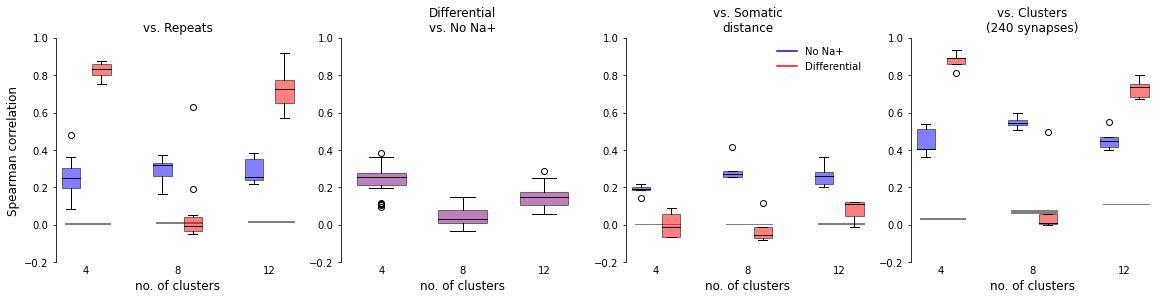

In [13]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

fig = plt.figure(constrained_layout=True, figsize = (16,4))
gs = fig.add_gridspec(1,12, wspace=0.1, hspace=0.35)
ax1 = fig.add_subplot(gs[0,:3])
ax2 = fig.add_subplot(gs[0,3:6])
ax3 = fig.add_subplot(gs[0,6:9])
ax4 = fig.add_subplot(gs[0,9:])
#ax5 = fig.add_subplot(gs[2,:4])
#ax6 = fig.add_subplot(gs[2,4:8])
#ax7 = fig.add_subplot(gs[2,8:])
#ax8 = fig.add_subplot(gs[1,:4])
#ax9 = fig.add_subplot(gs[1,4:8])
#ax10 = fig.add_subplot(gs[1,8:])

colors=["blue", "red", "blue", "red", "blue", "red"]
bp = ax1.boxplot(within_corrs_weighted[:,:-3], positions=[1,2,4,5,7,8], widths=0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
ax1.fill_between(np.arange(0.8,2.3,0.01), np.mean(within_corrs_weighted[:,-3])-np.std(within_corrs_weighted[:,-3]),
                 np.mean(within_corrs_weighted[:,-3])+np.std(within_corrs_weighted[:,-3]), color="gray")
ax1.fill_between(np.arange(3.8,5.3,0.01), np.mean(within_corrs_weighted[:,-2])-np.std(within_corrs_weighted[:,-2]),
                 np.mean(within_corrs_weighted[:,-2])+np.std(within_corrs_weighted[:,-2]), color="gray")
ax1.fill_between(np.arange(6.8,8.3,0.01), np.mean(within_corrs_weighted[:,-1])-np.std(within_corrs_weighted[:,-1]),
                 np.mean(within_corrs_weighted[:,-1])+np.std(within_corrs_weighted[:,-1]), color="gray")
    
hB, = ax1.plot(1,1,'blue')
hR, = ax1.plot(1,1,'red')
ax3.legend((hB, hR),('No Na+', 'Differential'), frameon=False, fontsize=10)
hB.set_visible(False)
hR.set_visible(False)

ax1.set_ylim(-0.2,1)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(False)
ax1.set_xticks([1.5, 4.5, 7.5])
ax1.set_xticklabels(["4", "8", "12"])
ax1.tick_params(axis="x", length=0)
ax1.set_xlabel("no. of clusters", fontsize=12)
ax1.set_ylabel("Spearman correlation", fontsize=12)
ax1.set_title("vs. Repeats", fontsize=12)

##################################
bp = ax2.boxplot(across_corrs_weighted, widths=0.6, patch_artist=True)

colors=["purple", "purple", "purple"]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
ax2.set_ylim(-0.2,1)
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)
ax2.spines.bottom.set_visible(False)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(["4", "8", "12"])
ax2.tick_params(axis="x", length=0)
ax2.set_xlabel("no. of clusters", fontsize=12)
ax2.set_title("Differential\nvs. No Na+", fontsize=12)

####################################
bp = ax3.boxplot(dist_corrs_weighted[:,:-3], positions=[1,2,4,5,7,8], widths=0.6, patch_artist=True)
colors=["blue", "red", "blue", "red", "blue", "red"]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
ax3.fill_between(np.arange(0.8,2.3,0.01), np.mean(dist_corrs_weighted[:,-3])-np.std(dist_corrs_weighted[:,-3]),
                 np.mean(dist_corrs_weighted[:,-3])+np.std(dist_corrs_weighted[:,-3]), color="gray")
ax3.fill_between(np.arange(3.8,5.3,0.01), np.mean(dist_corrs_weighted[:,-2])-np.std(dist_corrs_weighted[:,-2]),
                 np.mean(dist_corrs_weighted[:,-2])+np.std(dist_corrs_weighted[:,-2]), color="gray")
ax3.fill_between(np.arange(6.8,8.3,0.01), np.mean(dist_corrs_weighted[:,-1])-np.std(dist_corrs_weighted[:,-1]),
                 np.mean(dist_corrs_weighted[:,-1])+np.std(dist_corrs_weighted[:,-1]), color="gray")

ax3.set_ylim(-0.2,1)
ax3.spines.right.set_visible(False)
ax3.spines.top.set_visible(False)
ax3.spines.bottom.set_visible(False)
ax3.set_xticks([1.5, 4.5, 7.5])
ax3.set_xticklabels(["4", "8", "12"])
ax3.tick_params(axis="x", length=0)
ax3.set_xlabel("no. of clusters", fontsize=12)
ax3.set_title("vs. Somatic\ndistance", fontsize=12)

####################################
bp = ax4.boxplot(clust_corrs_weighted[:,:-3], positions=[1,2,4,5,7,8], widths=0.6, patch_artist=True)
colors=["blue", "red", "blue", "red", "blue", "red"]

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
ax4.fill_between(np.arange(0.8,2.3,0.01), np.mean(clust_corrs_weighted[:,-3])-np.std(clust_corrs_weighted[:,-3]),
                 np.mean(clust_corrs_weighted[:,-3])+np.std(clust_corrs_weighted[:,-3]), color="gray")
ax4.fill_between(np.arange(3.8,5.3,0.01), np.mean(clust_corrs_weighted[:,-2])-np.std(clust_corrs_weighted[:,-2]),
                 np.mean(clust_corrs_weighted[:,-2])+np.std(clust_corrs_weighted[:,-2]), color="gray")
ax4.fill_between(np.arange(6.8,8.3,0.01), np.mean(clust_corrs_weighted[:,-1])-np.std(clust_corrs_weighted[:,-1]),
                 np.mean(clust_corrs_weighted[:,-1])+np.std(clust_corrs_weighted[:,-1]), color="gray")

ax4.set_ylim(-0.2,1)
ax4.spines.right.set_visible(False)
ax4.spines.top.set_visible(False)
ax4.spines.bottom.set_visible(False)
ax4.set_xticks([1.5, 4.5, 7.5])
ax4.set_xticklabels(["4", "8", "12"])
ax4.tick_params(axis="x", length=0)
ax4.set_xlabel("no. of clusters", fontsize=12)
ax4.set_title("vs. Clusters\n(240 synapses)", fontsize=12)

"""
######################################
im1 = ax5.imshow(C4_diff_heatmap_weighted, origin='lower', vmin=0, vmax=1, cmap="jet")
im2 = ax8.imshow(C4_nona_heatmap_weighted, origin='lower', vmin=0, vmax=1, cmap="jet")
im3 = ax6.imshow(C8_diff_heatmap_weighted, origin='lower', vmin=0, vmax=1, cmap="jet")
im4 = ax9.imshow(C8_nona_heatmap_weighted, origin='lower', vmin=0, vmax=1, cmap="jet")
im5 = ax7.imshow(C12_diff_heatmap_weighted, origin='lower', vmin=0, vmax=1, cmap="jet")
im6 = ax10.imshow(C12_nona_heatmap_weighted, origin='lower', vmin=0, vmax=1, cmap="jet")

plt.colorbar(im1, ax=ax5)
plt.colorbar(im2, ax=ax8)
plt.colorbar(im3, ax=ax6)
plt.colorbar(im4, ax=ax9)
plt.colorbar(im5, ax=ax7)
plt.colorbar(im6, ax=ax10)

ax5.set_title("Differential (4 clusters)", fontsize=12)
ax8.set_title("No Na+ (4 clusters)", fontsize=12)
ax6.set_title("Differential (8 clusters)", fontsize=12)
ax9.set_title("No Na+ (8 clusters)", fontsize=12)
ax7.set_title("Differential (12 clusters)", fontsize=12)
ax10.set_title("No Na+ (12 clusters)", fontsize=12)

for ax in [ax5,ax6,ax7,ax8,ax9,ax10]:
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(["1","2","3","4","5"])
    ax.set_yticklabels(["1","2","3","4","5","Soma Dist.", "Clusters", "Random"])
"""

fig.tight_layout()
#plt.show()
fig.savefig("/home/sklee/dendrite/fig9/fig9_raw.pdf", bbox_inches="tight", transparent=True)